In [1]:
import csv
import pickle
import json
import spacy
import re
import string
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

In [2]:
# read in train questions and answers
qa = pd.read_csv('D:\\Data\\GoogleQuestion\\train.csv', encoding = "ISO-8859-1")

In [3]:
# display head entries
qa.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y Â Â e Â Â z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [4]:
# list target columns and input columns
target_columns = [
        'question_asker_intent_understanding',
        'question_body_critical',
        'question_conversational',
        'question_expect_short_answer',
        'question_fact_seeking',
        'question_has_commonly_accepted_answer',
        'question_interestingness_others',
        'question_interestingness_self',
        'question_multi_intent',
        'question_not_really_a_question',
        'question_opinion_seeking',
        'question_type_choice',
        'question_type_compare',
        'question_type_consequence',
        'question_type_definition',
        'question_type_entity',
        'question_type_instructions',
        'question_type_procedure',
        'question_type_reason_explanation',
        'question_type_spelling',
        'question_well_written',
        'answer_helpful',
        'answer_level_of_information',
        'answer_plausible',
        'answer_relevance',
        'answer_satisfaction',
        'answer_type_instructions',
        'answer_type_procedure',
        'answer_type_reason_explanation',
        'answer_well_written'    
    ]

num_targets = len(target_columns)
input_columns = ['question_title', 'question_body', 'answer']
qa['question'] = qa['question_body'] + ' ' + qa['question_title']

In [5]:
# convert panda columns to numpy arrays for pre-processing with Spacy
questions = qa['question'].values
answers = qa['answer'].values
y = qa[target_columns].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [6]:
# This notebook "cleans" tweets manually and does not use any existing machinery from "really good" packages such as Spacy and NLTK; hence stop words from Gensim are listed here 
# (with negation removed) and removed as appropriate (This list is presented here since it facilitates inclusion of additional stop words and removal if meaning is being lost...)
stop_words = ['her', 'during', 'among', 'thereafter', 'only', 'hers', 'in', 'with', 'un', 'put', 'hence', 'each', 'would', 'have', 'to', 'itself', 'that', 'seeming', 
              'hereupon', 'someone', 'eight', 'she', 'forty', 'much', 'throughout', 'less', 'was', 'interest', 'elsewhere', 'already', 'whatever', 'or', 'seem', 'fire', 
              'however', 'keep', 'detail', 'both', 'yourselves', 'indeed', 'enough', 'too', 'us', 'wherein', 'himself', 'behind', 'everything', 'part', 'made', 'thereupon', 
              'for', 'before', 'front', 'sincere', 'really', 'than', 'alone', 'doing', 'amongst', 'across', 'him', 'another', 'some', 'whoever', 'four', 'other', 
              'latterly', 'off', 'sometime', 'above', 'often', 'herein', 'am', 'whereby', 'although', 'who', 'should', 'amount', 'anyway', 'else', 'upon', 'this', 'when', 
              'we', 'few', 'anywhere', 'will', 'though', 'being', 'fill', 'used', 'full', 'thru', 'call', 'whereafter', 'various', 'has', 'same', 'former', 'whereas', 'what', 
              'had', 'mostly', 'onto', 'go', 'could', 'yourself', 'meanwhile', 'beyond', 'beside', 'ours', 'side', 'our', 'five', 'nobody', 'herself', 'is', 'ever', 'they', 'here', 
              'eleven', 'fifty', 'therefore', 'mill', 'without', 'whence', 'get', 'whither', 'then', 'own', 'many', 'anything', 'etc', 'make', 'from', 
              'ltd', 'next', 'afterwards', 'unless', 'while', 'thin', 'beforehand', 'by', 'amoungst', 'you', 'third', 'as', 'those', 'done', 'becoming', 'say', 'either', 
              'doesn', 'twenty', 'his', 'yet', 'latter', 'somehow', 'are', 'these', 'mine', 'under', 'take', 'whose', 'others', 'over', 'perhaps', 'thence', 'does', 'where', 
              'two', 'always', 'your', 'wherever', 'became', 'which', 'about', 'but', 'towards', 'still', 'rather', 'quite', 'whether', 'somewhere', 'might', 'do', 'bottom', 
              'until', 'km', 'yours', 'serious', 'find', 'please', 'otherwise', 'six', 'toward', 'sometimes', 'of', 'fifteen', 'eg', 'just', 'a', 'me', 'describe', 
              'why', 'an', 'and', 'may', 'within', 'kg', 'con', 're', 'nevertheless', 'through', 'very', 'anyhow', 'down', 'now', 'it', 'de', 'move', 'hereby', 
              'how', 'found', 'whom', 'were', 'together', 'again', 'moreover', 'first', 'below', 'between', 'computer', 'ten', 'into', 'see', 'everywhere', 'there', 
              'neither', 'every', 'couldnt', 'up', 'several', 'the', 'i', 'becomes', 'don', 'ie', 'been', 'whereupon', 'seemed', 'most', 'noone', 'whole', 'must', 'per', 
              'my', 'thereby', 'so', 'he', 'name', 'co', 'its', 'everyone', 'if', 'become', 'thick', 'thus', 'regarding', 'give', 'all', 'show', 'any', 'using', 'on', 
              'further', 'around', 'back', 'least', 'since', 'anyone', 'once', 'can', 'bill', 'hereafter', 'be', 'seems', 'their', 'myself', 'nine', 'also', 'system', 'at', 'more', 
              'out', 'twelve', 'therein', 'almost', 'except', 'last', 'did', 'something', 'besides', 'via', 'whenever', 'formerly', 'cry', 'one', 'hundred', 'sixty', 'after', 
              'well', 'them', 'namely', 'empty', 'three', 'even', 'along', 'because', 'ourselves', 'such', 'top', 'due', 'inc', 'themselves']

In [7]:
def clean_text(text):
    '''
    Remove tokens that are punctuation, numbers, symbols, urls or stop words
    '''
    text = re.sub(r'http\S+', '', text.strip()).lower()                                        # remove urls
    text = re.sub(r'[^A-Za-z ]+', ' ', text)                                                   # remove nonalpha
    words = [word for word in text.split() if word not in stop_words and len(word) > 2]        # remove stop words
    return words                                                                               # return list of words

In [8]:
# clean questions and answers
start_time = time.time()

question_words = []               # question vocabulary
question_lengths = []             # cleaned question word lengths
for idx in range(len(questions)):
    words = clean_text(str(questions[idx]))
    question_lengths.append(len(words))
    questions[idx] = " ".join(words)
    for w in words:
        question_words.append(w) if w not in question_words else question_words
                 
answer_words = []                # answer vocabulary
answer_lengths = []              # cleaned answer word lengths
for idx in range(len(answers)):
    words = clean_text(str(answers[idx]))
    answer_lengths.append(len(words))
    answers[idx] = " ".join(words)
    for w in words:
        answer_words.append(w) if w not in answer_words else answer_words
                 
print('FINISH CLEANING train.csv... elapsed time: {} sec'.format(time.time() - start_time))

FINISH CLEANING train.csv... elapsed time: 49.07065272331238 sec


In [9]:
# show 80% and 90% percentiles for question and answer lengths
print('Question 95 percentile = {:.1f}, 98 percentile = {:.1f}'.format(np.percentile(question_lengths, 95), np.percentile(question_lengths, 98)))
print('Answer 95 percentile = {:.1f}, 98 percentile = {:.1f}'.format(np.percentile(answer_lengths, 95), np.percentile(answer_lengths, 98)))

Question 95 percentile = 180.0, 98 percentile = 282.4
Answer 95 percentile = 188.0, 98 percentile = 269.0


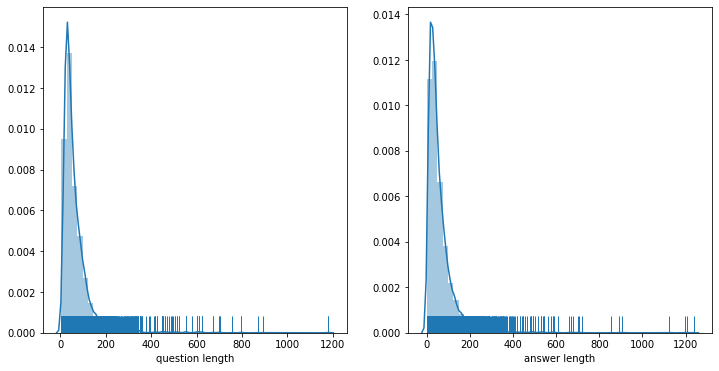

In [10]:
# Plot question/answer word length distributions (post cleaning)
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
sns.distplot(question_lengths, ax=ax1, norm_hist=True, rug=True, axlabel='question length')
sns.distplot(answer_lengths, ax=ax2, norm_hist=True, rug=True, axlabel='answer length')
plt.show()

In [11]:
# method to form word clouds from text
def word_cloud(word_dict):
    # generate the wordcloud using the series created and the mask 
    wc = WordCloud(width=2000, height=1000, max_font_size=200,  background_color="black", max_words=500, contour_width=1, contour_color="steelblue", colormap="nipy_spectral")
    wc.generate_from_frequencies(word_dict)

    plt.figure(figsize=(14, 7))
    # plt.imshow(wc, interpolation="bilinear")
    plt.imshow(wc, interpolation="hermite")
    plt.axis("off")    
    plt.show() 

In [12]:
# method to create word frequency dict from list of tweets
def word_dict(texts):
    words = {}
    for text in texts:
        text_list = text.split(' ')
        for t in text_list:
            if t in words:
                words[t] += 1
            else:
                words[t] = 1
    return {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

QUESTIONS


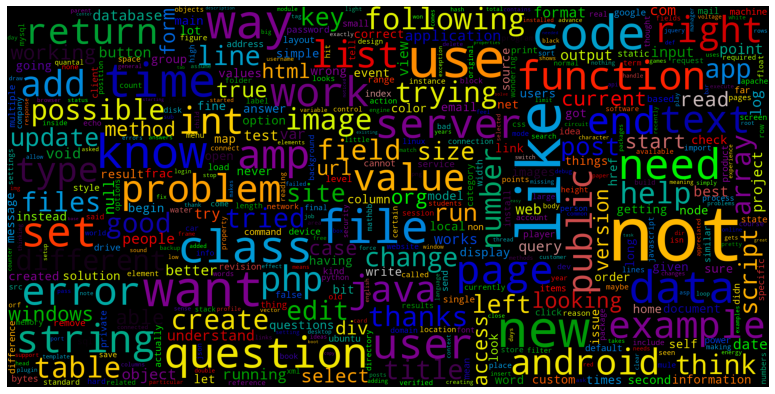

ANSWERS


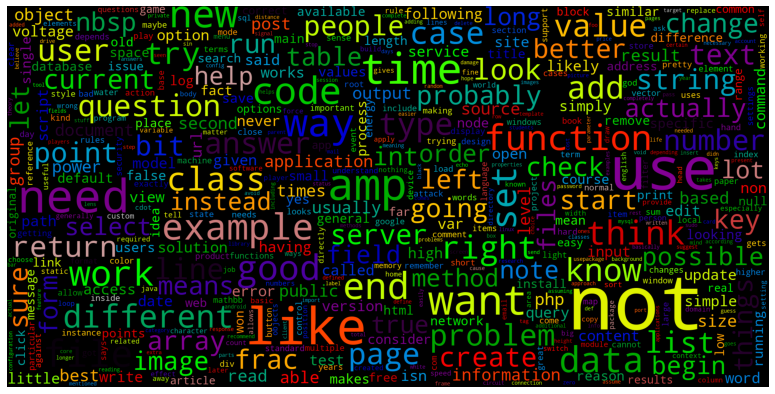

In [13]:
# determine word frequency in questions and answers
question_dict = word_dict(questions)
answer_dict = word_dict(answers)
# display word clouds for questions and answers
print("QUESTIONS")
word_cloud(question_dict)
print("ANSWERS")
word_cloud(answer_dict)

In [14]:
# method to show word frequencies in Q/A dicts
def show_frequencies(word_dict, dict_name):
    labels = list(word_dict.keys())
    values = list(word_dict.values())
    title = "Word Frequency for {}".format(dict_name)
    
    plt.figure(figsize=(14, 7))
    plt.bar(np.arange(50), values[0: 50], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, edgecolor = "black", capsize=8, linewidth=1)
    plt.xticks(np.arange(50), labels[0: 50], rotation=90, size=14)
    plt.xlabel("Most Frequent Words", size=14)
    plt.ylabel("Frequency", size=14)
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

QUESTIONS


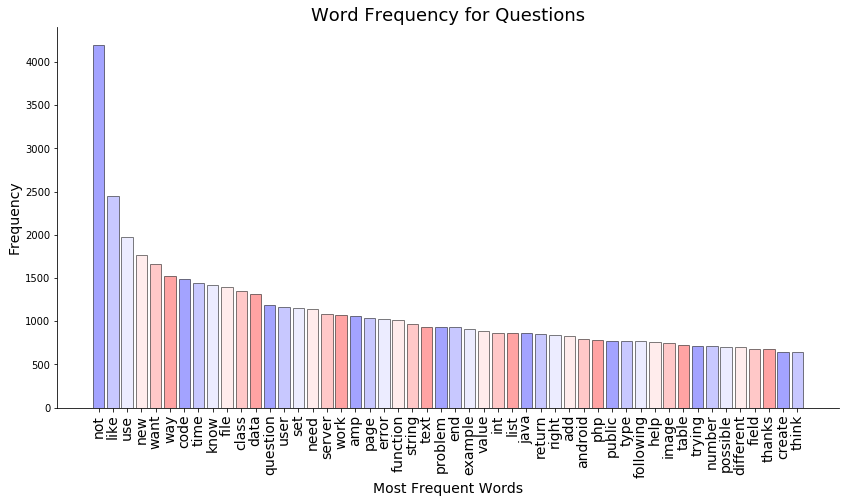

ANSWERS


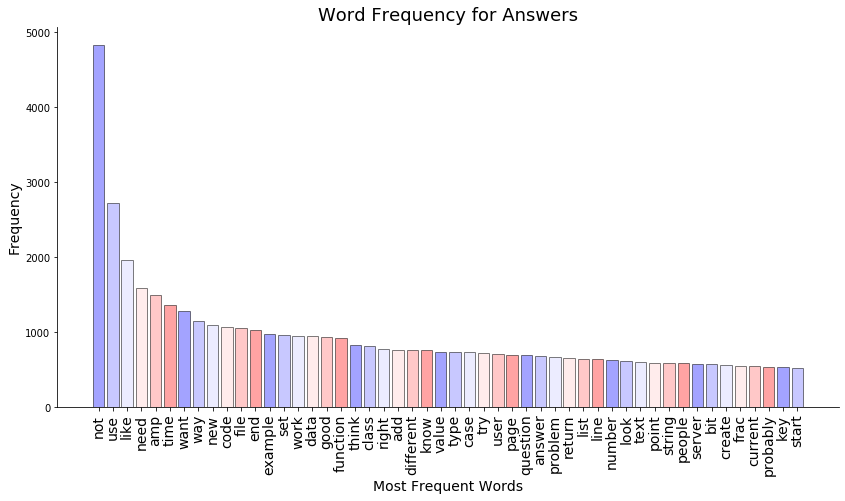

In [15]:
# show word frequency plots for questions and answers
print("QUESTIONS")
show_frequencies(question_dict, "Questions")
print("ANSWERS")
show_frequencies(answer_dict, "Answers")

In [16]:
# method to show correlation between word frequencies in questions and answers
def correlation_plot(table):
    table = table[1:]
    sns.set_style("whitegrid")   
    plt.figure(figsize=(12, 10))
    points = plt.scatter(table["question"], table["answer"], c=table["question"], s=75, cmap="bwr")
    plt.colorbar(points)
    sns.regplot(x="question", y="answer",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Questions", size=14)
    plt.ylabel("Frequency for Answers", size=14)
    plt.title("Word Frequency Correlation - Questions vs Answers", size=14)
    plt.grid(False)
    sns.despine()

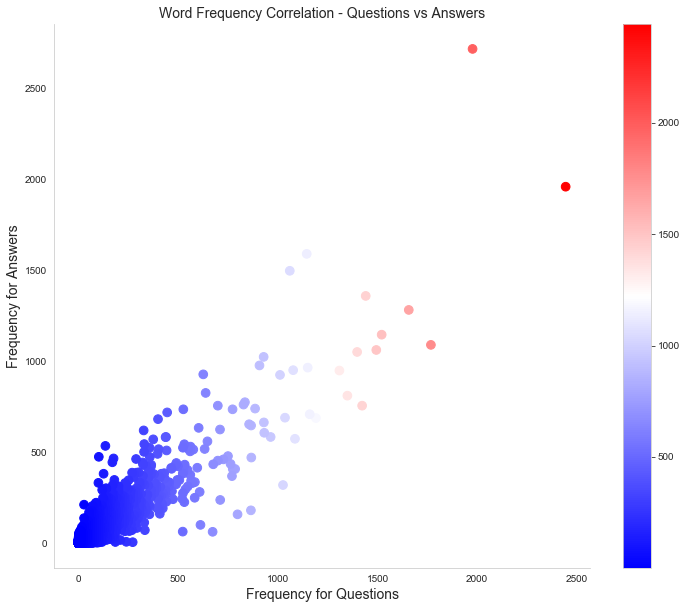

In [17]:
q = pd.DataFrame(question_dict.items())
q.columns = ['word', 'question']
a = pd.DataFrame(answer_dict.items())
a.columns = ['word', 'answer']
corr = pd.merge(q, a, on='word').drop(['word'], axis=1)
correlation_plot(corr)

In [18]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# set question/answer length to include 98 percentile 
MAX_WORDS = 280

# Create Tokenization Index Dict and Label Dict
tokenizer = Tokenizer(lower=True, filters='', num_words=None, oov_token='<UNK>')     
tokenizer.fit_on_texts(questions + answers) 

# question/answer word index
word_index = tokenizer.word_index

# Encode questions/answers into sequences
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(answers)

# Get max question/answer length
max_question = max([len(x) for x in question_sequences])
max_answer = max([len(x) for x in answer_sequences])

# Pad the question/answer sequences
XQ = pad_sequences(question_sequences, padding='post', truncating='pre', maxlen=MAX_WORDS)
XA = pad_sequences(answer_sequences, padding='post', truncating='pre', maxlen=MAX_WORDS)

print("Number of Entries: Question Tokens = {} -- Answer Tokens = {} -- Labels = {}".format(XQ.shape, XA.shape, y.shape))

Number of Entries: Question Tokens = (6079, 280) -- Answer Tokens = (6079, 280) -- Labels = (6079, 30)


In [19]:
# bidirectional LSTM model with multihead (self) attention for both questions and answered concatenated thru a final linear layer with activation 
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import models, initializers, Model
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, ReLU, LSTM, Bidirectional, Lambda, LayerNormalization, TimeDistributed, Activation
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate

# implement (dot product) attention with scaling
class Attention():
    def __init__(self, dim, dropout=0.1):
        self.temperature = np.sqrt(dim)
        self.dropout = Dropout(dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x: K.batch_dot(x[0], x[1], axes=[2,2]) / self.temperature)([q, k])
        if mask is not None:
            attn = Add()([attn, Lambda(lambda x: (-1e+10) * (1 - x))(mask)])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x: K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

# implement multi-head attention using dot product attention
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, num_head=15, dim=100, num_key=64, num_val=64, dropout=0.1):
        self.num_head = num_head
        self.dim = dim
        self.num_key = num_key
        self.num_val = num_val
        self.dropout = dropout
        self.qlayer = Dense(num_head * num_key, use_bias=False)
        self.klayer = Dense(num_head * num_key, use_bias=False)
        self.vlayer = Dense(num_head * num_val, use_bias=False)
        self.attention = Attention(dim)
        self.layer_norm = LayerNormalization()
        self.w_o = TimeDistributed(Dense(dim))

    def __call__(self, q, k, v, mask=None):
        ql = self.qlayer(q)   # [batch_size, len_q, num_head * num_key]
        kl = self.klayer(k)
        vl = self.vlayer(v)

        def reshape1(x):
            s = tf.shape(x)   # [batch_size, len_q, num_head * num_key]
            x = tf.reshape(x, [s[0], s[1], self.num_head, self.num_key])
            x = tf.transpose(x, [2, 0, 1, 3])  
            x = tf.reshape(x, [-1, s[1], self.num_key])  # [num_head * batch_size, len_q, num_key]
            return x
        
        ql = Lambda(reshape1)(ql)
        kl = Lambda(reshape1)(kl)
        vl = Lambda(reshape1)(vl)

        if mask is not None:
            mask = Lambda(lambda x: K.repeat_elements(x, self.num_head, 0))(mask)
        head, attn = self.attention(ql, kl, vl, mask=mask)  
                
        def reshape2(x):
            s = tf.shape(x)   # [num_head * batch_size, len_v, num_val]
            x = tf.reshape(x, [self.num_head, -1, s[1], s[2]]) 
            x = tf.transpose(x, [1, 2, 0, 3])
            x = tf.reshape(x, [-1, s[1], self.num_head * self.num_val])  # [batch_size, len_v, num_head * num_val]
            return x
        
        head = Lambda(reshape2)(head)

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)

        return self.layer_norm(outputs), attn

# Bidirectional LSTM with multihead attention (embedded layer trained with model)
def bilstm_attn(max_word_index, num_feature, num_class=30, embedding_dim=100, dropout=0.1):  

    input_q = Input(shape=(num_feature))          
    input_a = Input(shape=(num_feature))         

    xq = Embedding(max_word_index, embedding_dim, input_length=num_feature)(input_q)      
    xa = Embedding(max_word_index, embedding_dim, input_length=num_feature)(input_a)   

    # Parallel BiLSTM layers with attention
    xq = Bidirectional(LSTM(num_feature, return_sequences=True))(xq)
    xq = Bidirectional(LSTM(num_feature, return_sequences=True))(xq)
    xa = Bidirectional(LSTM(num_feature, return_sequences=True))(xa)
    xa = Bidirectional(LSTM(num_feature, return_sequences=True))(xa)
    
    # Attention Layer
    xq, attn_q = MultiHeadAttention(num_head=15, num_key=num_feature, num_val=num_feature, dropout=dropout)(xq, xq, xq)
    avg1d_q = GlobalAveragePooling1D()(xq)
    max1d_q = GlobalMaxPooling1D()(xq)
    
    xa, attn_a = MultiHeadAttention(num_head=15, num_key=num_feature, num_val=num_feature, dropout=dropout)(xa, xa, xa)
    avg1d_a = GlobalAveragePooling1D()(xa)
    max1d_a = GlobalMaxPooling1D()(xa)
    
    x = Concatenate()([avg1d_q, max1d_q, avg1d_a, max1d_a])
    x = Dense(256, activation='relu')(x)
    x = Dense(num_class, activation='sigmoid')(x)

    model = Model(inputs=[input_q, input_a], outputs=x)
    model.compile(tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True), 'binary_crossentropy', metrics=['mae'])
    return model

In [20]:
# Plot Model History
def plot(epochs, history):
    xdata = list(range(1, epochs + 1))
    plt.plot(xdata, history['mae'],      label='Train MAE')
    plt.plot(xdata, history['val_mae'],  label='Val MAE')
    plt.plot(xdata, history['loss'],     label='Train Loss')
    plt.plot(xdata, history['val_loss'], label='Val Loss')
 
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy/Loss")
    plt.ylim(0, 0.5)
    plt.legend()
    plt.show()

In [21]:
from sklearn.model_selection import train_test_split
# split training data for test and validation
seed = 42
np.random.seed(seed)
EPOCHS = 10
BATCH_SIZE = 16
# Split training data 80/20 train/test split (include original unscaled labels for spearman rho correlation)
XQ_train, XQ_val, XA_train, XA_val, y_train, y_val, targ_train, targ_val = train_test_split(XQ, XA, y, qa[target_columns].values, test_size=0.2, random_state=seed)
print("sample shapes: XQ={}, XA={}, y={}".format(XQ.shape, XA.shape, y.shape))
print("train  shapes: XQ={}, XA={}, y={}".format(XQ_train.shape, XA_train.shape, y_train.shape))
print("val    shapes: XQ={}, XA={}, y={}".format(XQ_val.shape, XA_val.shape, y_val.shape))

sample shapes: XQ=(6079, 280), XA=(6079, 280), y=(6079, 30)
train  shapes: XQ=(4863, 280), XA=(4863, 280), y=(4863, 30)
val    shapes: XQ=(1216, 280), XA=(1216, 280), y=(1216, 30)


Num GPUs Available:  1
Train on 4863 samples, validate on 1216 samples
Epoch 1/10
4863/4863 [==============================] - 178s 37ms/sample - loss: 0.4451 - mae: 0.1927 - val_loss: 0.4598 - val_mae: 0.1956
Epoch 2/10
4863/4863 [==============================] - 165s 34ms/sample - loss: 0.4397 - mae: 0.1889 - val_loss: 0.4580 - val_mae: 0.1917
Epoch 3/10
4863/4863 [==============================] - 166s 34ms/sample - loss: 0.4390 - mae: 0.1881 - val_loss: 0.4566 - val_mae: 0.1914
Epoch 4/10
4863/4863 [==============================] - 166s 34ms/sample - loss: 0.4381 - mae: 0.1878 - val_loss: 0.4577 - val_mae: 0.1918
Epoch 5/10
4863/4863 [==============================] - 166s 34ms/sample - loss: 0.4377 - mae: 0.1874 - val_loss: 0.4543 - val_mae: 0.1923
Epoch 6/10
4863/4863 [==============================] - 165s 34ms/sample - loss: 0.4374 - mae: 0.1873 - val_loss: 0.4575 - val_mae: 0.1919
Epoch 7/10
4863/4863 [==============================] - 166s 34ms/sample - loss: 0.4372 - mae: 

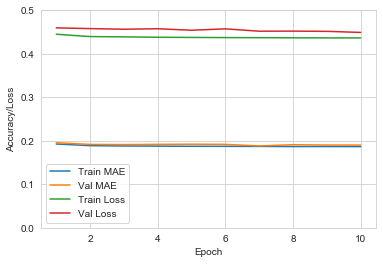

In [22]:
# train BiLSTM model
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print("Num GPUs Available: ", len(physical_devices))
start_time = time.time()  
bilstm_attn_model = bilstm_attn(max(word_index.values()) + 1, MAX_WORDS)
history = bilstm_attn_model.fit([XQ_train, XA_train], y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=([XQ_val, XA_val], y_val))
print('\nBiLSTM TRAINING AND VALIDATION COMPLETE... elapsed time: {} sec'.format(time.time() - start_time))

print("\n")
print(history.history)
print("\n")
plot(EPOCHS, history.history)

In [24]:
from scipy import stats

# calculate Spearman Rho Correlation (Google's Requested Metric)
spear_train = np.empty(XQ_train.shape[0])
for idx in range(XQ_train.shape[0]):
    yp = bilstm_attn_model.predict([XQ_train[idx: idx + 1, :], XA_train[idx: idx + 1, :]])
    spear_train[idx], _ = stats.spearmanr(targ_train[idx, :], yp, axis=1)

spear_val = np.empty(XQ_val.shape[0])
for idx in range(XQ_val.shape[0]):
    yp = bilstm_attn_model.predict([XQ_val[idx: idx + 1, :], XA_val[idx: idx + 1, :]])
    spear_val[idx], _ = stats.spearmanr(targ_val[idx, :], yp, axis=1)

In [25]:
print("Avg Train Spearman Rho: Mean={:.3f}, StdDev={:.3f}".format(np.mean(spear_train), np.std(spear_train)))
print("Avg Validation Spearman Rho: Mean={:.3f}, StdDev={:.3f}".format(np.mean(spear_val), np.std(spear_val)))

Avg Train Spearman Rho: Mean=0.771, StdDev=0.089
Avg Validation Spearman Rho: Mean=0.768, StdDev=0.091
